## ML Review and Gradient Descent Example

In this notebook, we will solve a simple linear regression problem by gradient descent.  
We will see the effect of the learning rate on the trajectory in parameter space.
We will show how Stochastic Gradient Descent (SGD) differs from the standard version, and the effect of "shuffling" your data during SGD.

In [ ]:
# Preliminaries - packages to load

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Generate Data from a known distribution
Below we will generate data from a known distribution.  
Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$

$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `const` is a vector of ones (representing the intercept term).

We set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1.5$, $\theta_1=2$, and $\theta_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`

In [ ]:
#Creo dei valori random
np.random.seed(1234)  ## This ensures we get the same data if all of the other parameters remain fixed

num_obs = 100
x1 = np.random.uniform(0,10,num_obs) #array di 100 elementi casuali con distribuzione uniforme tra 0 e 10
x2 = np.random.uniform(0,10,num_obs)
const = np.ones(num_obs) #array di 100 valori = 1
eps = np.random.normal(0,.5,num_obs) #array di valori con distribuzione a campana con media 0 e varianza .5 -> rapprensenta il rumore per avere una nuova nell'intorno del modello

#setting casuale dei pesi iniziali
b = 1.5
theta_1 = 2
theta_2 = 5

#calcolo il modello tramite numpy (eseguo operazione valore per valore come se non fosse un array)
y0 = b*const+ theta_1*x1 + theta_2*x2 + eps # computes y0
#risultato -> array di 100 elementi con etichette (regressione! non classificazione)

                                 #                              const
x_mat0 = np.array([const,x1,x2]) # creates a matrix containing   x1
                                 #                               x2

#mescolo i valori per aumentare la casualità, creo una matrice con le y associate alle relative x
#poi mescolo le righe di questa matrice tramite shuffle:
                                              #                   y0.T
t = np.concatenate((np.array([y0.T]),x_mat0)) # creates a matrix  const
                                              #                    x1
                                              #                    x2

t = t.T # creates a matrix where each row i contains y0[i], const[i], x1[i], x2[i]

np.random.shuffle(t) # moves randomly the rows
#risuddivido le x e le y usando lo slicing (ottengo di nuovo due matrici)
y=t[:,0] # takes first column (0) from all rows
x_mat=t[:,1:4] # takes columns 1-4 from all rows

print(y) #array
print(x_mat) #matrice
#Ho ottenuto il dataset

[21.98268992 50.57415314 21.26197374 67.50716747 28.54311841 66.44763571
 44.00060834 37.71052691 44.71835284 20.38572724 26.00356206 27.28704805
 41.75856245 38.7473009  59.23483932  8.04255882 47.54794318 37.95472396
 15.39651807 55.68703273 39.3098874  43.33256307 44.53288089 29.14388523
 60.38206962 33.87971392 58.51638392 61.45032297 56.98867987 52.83723556
 42.91055714 47.70514501 36.17605578 28.68651837 38.12132178 25.82169038
 17.09886071 46.69545869 18.22335359 24.07880006 40.06492289 14.03439564
 52.26455684 43.66214118 32.9317196  26.74897285 17.88772884 52.51954727
 52.67558512 28.54755755  2.90129951 62.68253254 51.77134925 25.46622631
 45.58928189 24.68094522 50.03522379 34.82376168 36.44677963 21.80088308
 49.44119069 41.96766483 34.96172003 49.76712273 49.70390141 25.71920238
 53.72035595 40.19213745 30.13641244 59.82862402 56.49680477 48.8695994
 10.89742951 43.1575642  42.61077066 46.6125824  16.72818759 46.23156426
 47.88288694 12.05602541 43.23633517  5.19228041 19.

## Get the "Right" answer directly
In the below cells we solve for the optimal set of coefficients.  Note that even though the true model is given by:

$b=1.5$, $\theta_1=2$, and $\theta_2=5$

The maximum likelihood (least-squares) estimate from a finite data set may be slightly different.

## Exercise:
Solve the problem two ways: 
1. By using the scikit-learn LinearRegression model
2. Using matrix algebra directly via the formula $\theta = (X^T X)^{-1}X^Ty$

Note: The scikit-learn solver may give a warning message, this can be ignored.

In [ ]:
### Solve directly using sklearn
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression(fit_intercept=False) # ensures that b is calculated
lr_model.fit(x_mat, y) #apprende i pesi della regressione lineare

lr_model.coef_ #ovvero b, teta1, teta2
#valori molto vicini a quelli forniti casualmente alll'inizio

array([1.49004618, 1.99675416, 5.01156315])

In [ ]:
## Solve by matrix calculation
#ulteriore rassicurazione sulla scelta dei datiusando un metodo direttamente matematico -> sempre regressione lineare
np.linalg.inv(np.dot(x_mat.T,x_mat)).dot(x_mat.T).dot(y)

array([1.49004618, 1.99675416, 5.01156315])

## Solving by Gradient Descent
##ULTERIORE METODO OLTRE AI PRECEDENTI


For most numerical problems, we don't / can't know the underlying analytical solution. This is because we only arrive at analytical solutions by solving the equations mathematically, with pen and paper. That is more often than not just impossible. Fortunately, we have a way of converging to an approximate solution, by using **Gradient Descent**.


We will explore this very useful method because Neural Networks, along with many other complicated algorithms, are trained using Gradient Descent.  Seeing how gradient descent works on a simple example will build intuition and help us understand some of the nuances around setting the learning rate and other parameters.  We will also explore Stochastic Gradient Descent and compare its behavior to the standard approach.

## Exercise

The next several cells have code to perform (full-batch) gradient descent.  We have omitted some parameters for you to fill in.

1. Pick a learning rate, and a number of iterations, run the code, and then plot the trajectory of your gradient descent.
1. Find examples where the learning rate is too high, too low, and "just right".
1. Look at plots of loss function under these conditions.



In [ ]:
## Parameters to play with 
learning_rate = 3e-3 #learning rate
num_iter = 10000
theta_initial = np.array([3,3,3]) #scelgo i valori iniziali dei miei pesi (casuali)

In [ ]:
def gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial #copia del teta iniziale
    theta_path = np.zeros((num_iter+1,3)) # matrice: contiene i valori dei pesi step per step
    theta_path[0,:]= theta_initial
    
    loss_vec = np.zeros(num_iter) #valori di loss calcolati mano a mano

    ## Main Gradient Descent loop (for a fixed number of iterations)
    for i in range(num_iter):
        y_pred = np.dot(theta.T,x_mat.T) #calcolo y predetta usando il modello con i pesi iniziali e matrice delle x
        loss_vec[i] = np.sum((y-y_pred)**2) #calcolo e salvo la loss
        grad_vec = (y-y_pred).dot(x_mat)/num_obs  #calcolo il gradiente: sum up the gradients across all observations and divide by num_obs
        # ^ This is 1/2 grad((y-y_pred)**2)=1/2*2(y-y_pred)*grad(y-y_pred) -> y is a constant, y_pred = b + theta1 x1 + theta2 x2. The gradient derivates y_pred in dtheta1 and dtheta2 so the gradient is x=[x1,x2] (b + theta1 x1 + theta2 x2)dtheta1 = x1
        #derivata dell'esterno * derivata dell'interno (sopra)
        #num_obs sarevve 1/n per ottenere il valore tra 0 e 1
        theta = theta + learning_rate*grad_vec #Nuovi valori di teta! gradient descend
        theta_path[i+1,:]=theta #salvo nello storico i valori dei pesi
    return theta_path, loss_vec

[1.52651172 1.99358055 5.00868455]


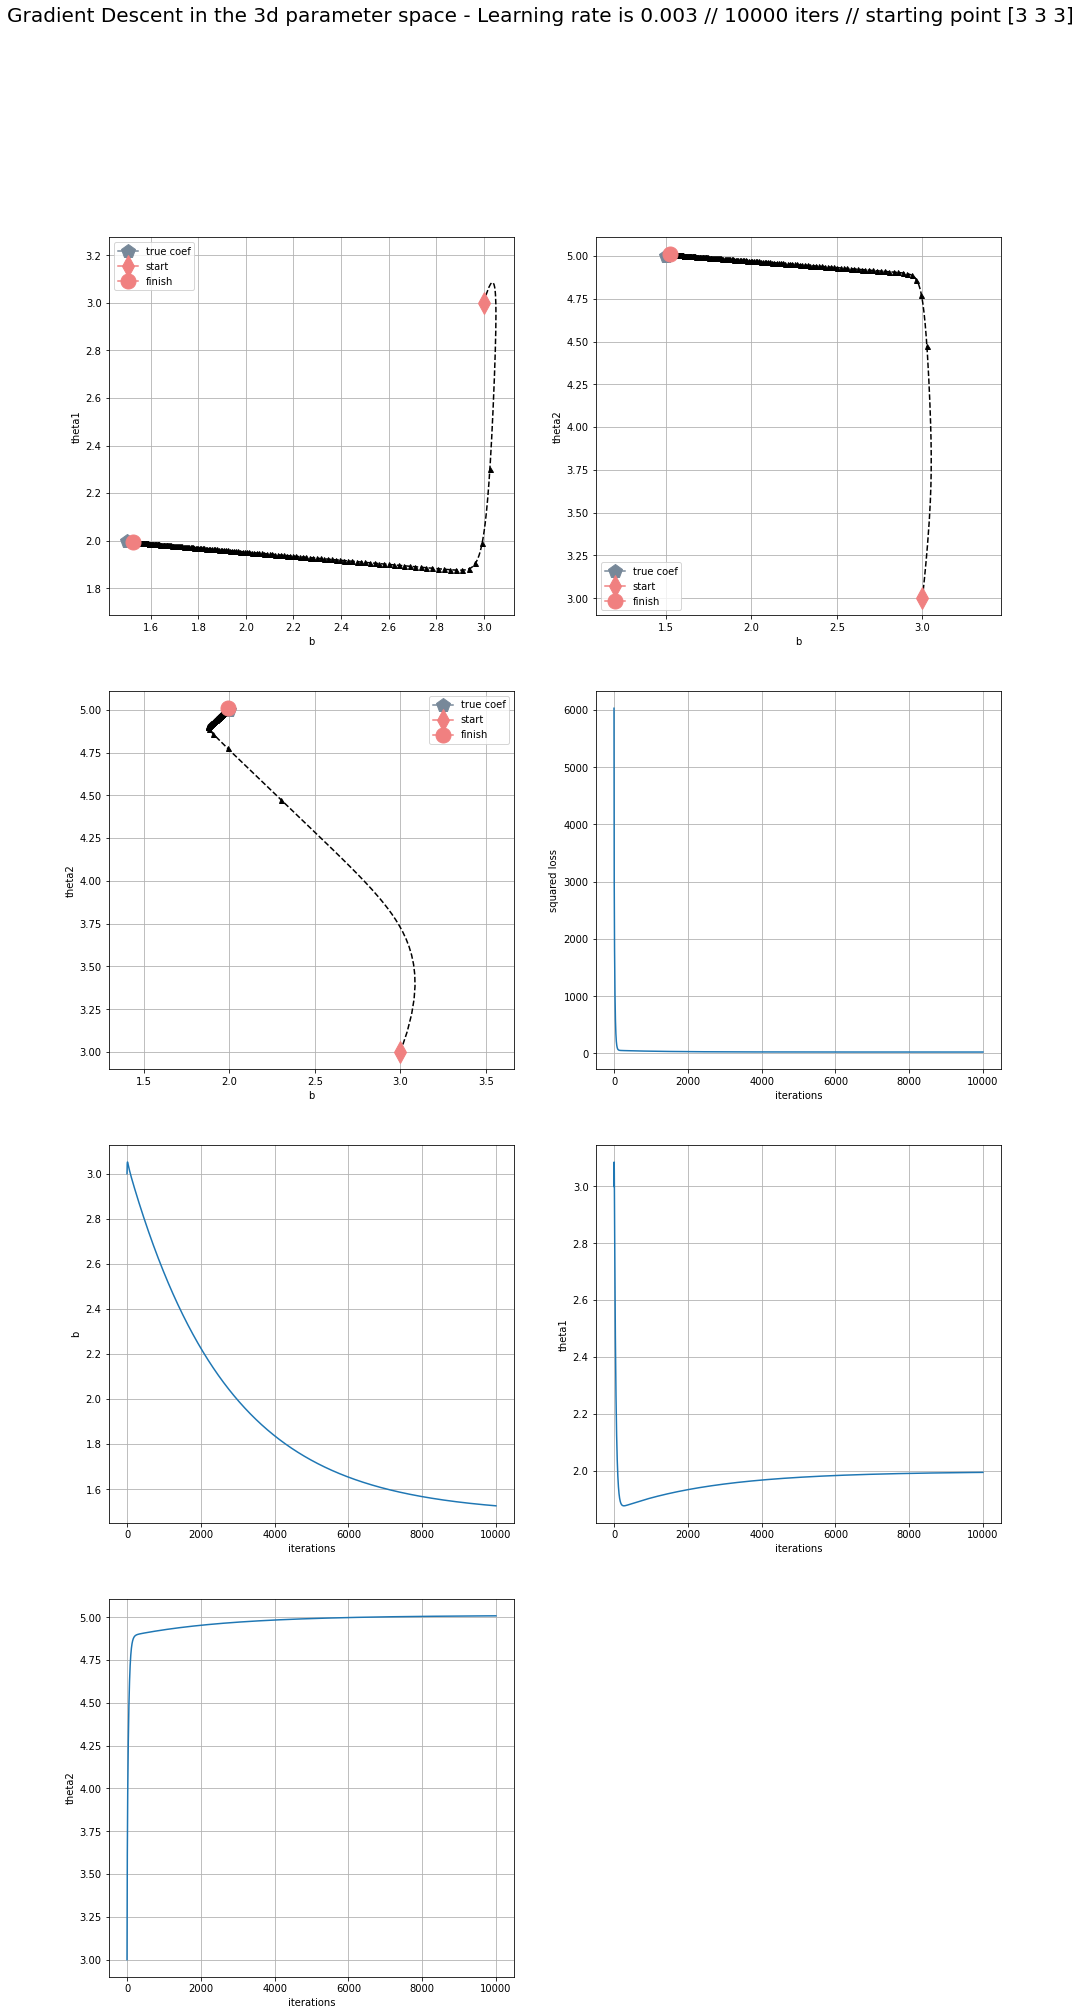

In [ ]:
true_coef = [b, theta_1, theta_2]

def plot_ij(theta_path, i, j, ax):
    ax.plot(true_coef[i], true_coef[j],
            marker='p', markersize=15, label='true coef', color='#778899')
    ax.plot(theta_path[:, i],theta_path[:, j],
            color='k', linestyle='--', marker='^', markersize=5, markevery=50)
    ax.plot(theta_path[0, i], theta_path[0, j], marker='d', markersize=15, label='start', color='#F08080')
    ax.plot(theta_path[-1, i], theta_path[-1, j], marker='o', markersize=15, label='finish', color='#F08080')
    ax.set(
        xlabel='theta'+str(i),
        ylabel='theta'+str(j))
    ax.axis('equal')
    ax.grid(True)
    ax.legend(loc='best')
    

def plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, gdtype='Gradient Descent'):
    plot_col = [4,2] # nrows, n col
    fig = plt.figure(figsize=(16, 32))
    title = '{gdtype} in the 3d parameter space - Learning rate is {lr} // {iters} iters // starting point {initial}'
    title = title.format(gdtype=gdtype, lr=learning_rate, iters=num_iter, initial=theta_initial)
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(plot_col[0],plot_col[1], 1)
    plot_ij(theta_path, 0, 1, ax)
    ax.set(xlabel='b')
    ax = fig.add_subplot(plot_col[0],plot_col[1], 2)
    plot_ij(theta_path, 0, 2, ax)
    ax.set(xlabel='b')
    ax = fig.add_subplot(plot_col[0],plot_col[1], 3)
    plot_ij(theta_path, 1, 2, ax)
    ax.set(xlabel='b')
    ax = fig.add_subplot(plot_col[0],plot_col[1], 4)
    ax.plot(loss_vec)
    ax.set(xlabel='iterations', ylabel='squared loss')
    ax.grid(True)
    ax = fig.add_subplot(plot_col[0],plot_col[1], 5)
    ax.plot(theta_path[:,0])
    ax.set(xlabel='iterations', ylabel='b')
    ax.grid(True)
    ax = fig.add_subplot(plot_col[0],plot_col[1], 6)
    ax.plot(theta_path[:,1])
    ax.set(xlabel='iterations', ylabel='theta1')
    ax.grid(True)
    ax = fig.add_subplot(plot_col[0],plot_col[1], 7)
    ax.plot(theta_path[:,2])
    ax.set(xlabel='iterations', ylabel='theta2')
    ax.grid(True)
    
    

theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)

print(theta_path[-1]) #ultimo peso appreso

## Stochastic Gradient Descent
Rather than average the gradients across the whole dataset before taking a step, we will now take a step for every datapoint.  Each step will be somewhat of an "overreaction" but they should average out.  

## Exercise
The below code runs Stochastic Gradient descent, but runs through the data in the same order every time.  

1. Run the code and plot the graphs.  What do you notice?
2. Modify the code so that it randomly re-orders the data.  How do the sample trajectories compare?

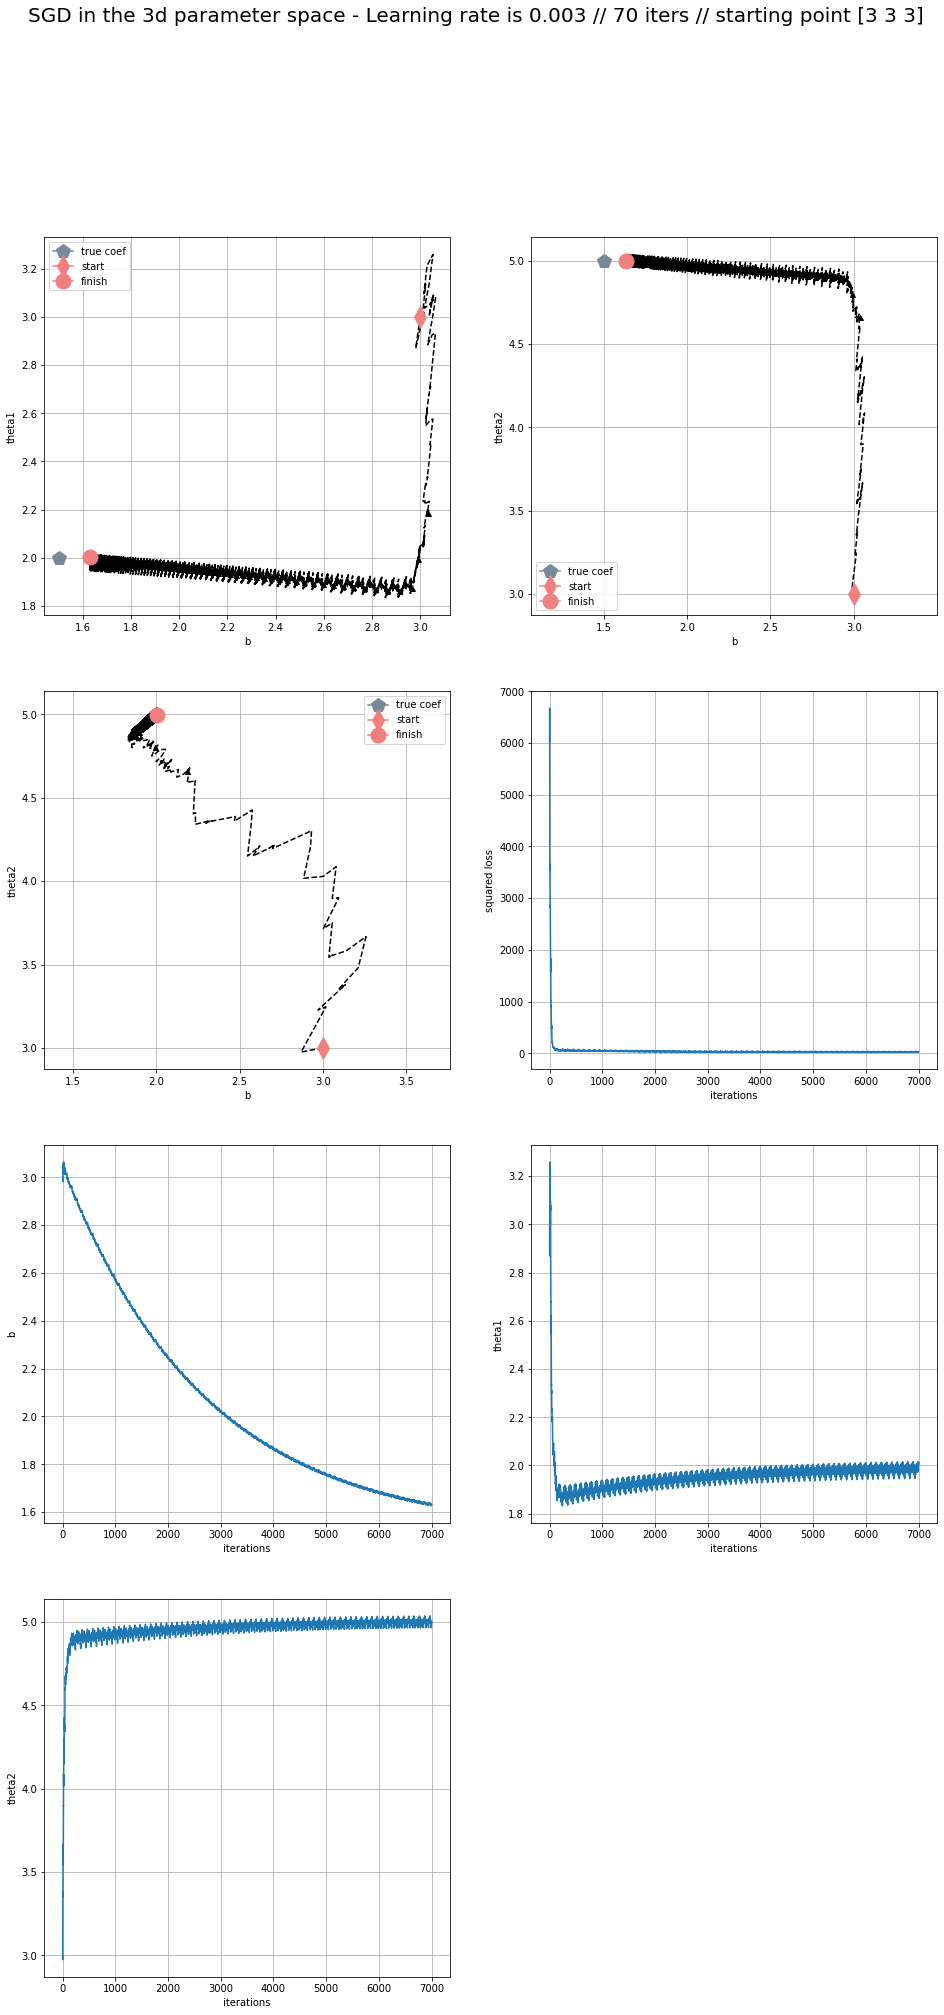

In [ ]:
def stochastic_gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    # below are different in STOCHASTIC gradient descent
    theta_path = np.zeros(((num_iter*num_obs)+1,3))
    theta_path[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*num_obs)

    ## Main SGD loop
    count = 0
    for i in range(num_iter):
        for j in range(num_obs):
            count+=1
            y_pred = np.dot(theta.T,x_mat.T)
            loss_vec[count-1] = np.sum((y-y_pred)**2)
            grad_vec = (y[j]-y_pred[j])*(x_mat[j,:])
            theta = theta + learning_rate*grad_vec
            theta_path[count,:]=theta
    return theta_path, loss_vec


def shuff_stochastic_gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    # below are different in STOCHASTIC gradient descent
    theta_path = np.zeros(((num_iter*num_obs)+1,3))
    theta_path[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*num_obs)

    ## Main SGD loop
    count = 0
    for i in range(num_iter):
        # How can we shuffle data?   
        # np.random.shuffle(t)    # x_mat and y are splices of t, by shuffling t we shuffle also them!
        for j in range(num_obs):
            count+=1
            y_pred = np.dot(theta.T,x_mat.T)
            loss_vec[count-1] = np.sum((y-y_pred)**2)
            grad_vec = (y[j]-y_pred[j])*(x_mat[j,:])
            theta = theta + learning_rate*grad_vec
            theta_path[count,:]=theta
    return theta_path, loss_vec

## Parameters to play with
learning_rate = 3e-3
num_iter = 70
theta_initial = np.array([3, 3, 3])

theta_path, loss_vec = stochastic_gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, 'SGD')

Play with the parameters below and observe the trajectory it results in

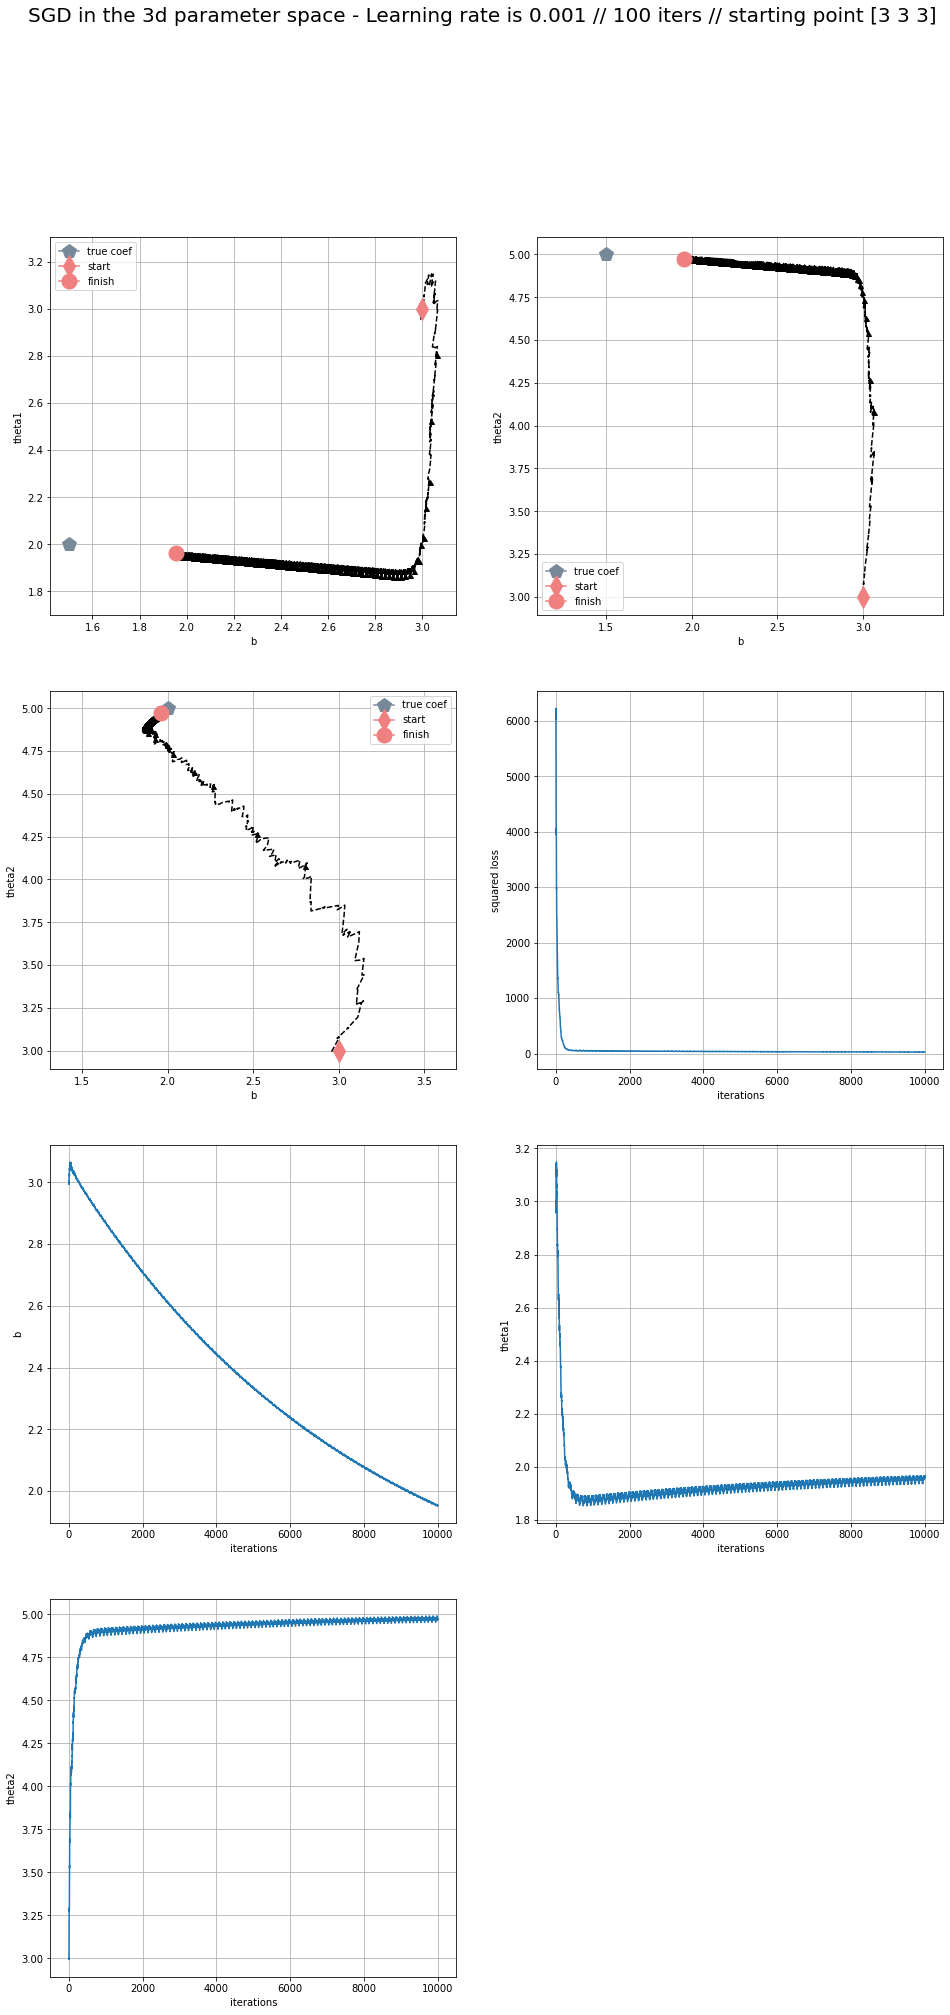

In [ ]:
## Parameters to play with
learning_rate = 1e-3
num_iter = 100
theta_initial = np.array([3,3,3])


theta_path, loss_vec = shuff_stochastic_gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, 'SGD')